<a href="https://colab.research.google.com/github/AnaBeaGeG/Projeto-Controladores/blob/main/Trabalho_Controle_Grupo_VIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabalho Sistemas de Controle I - 2024.2

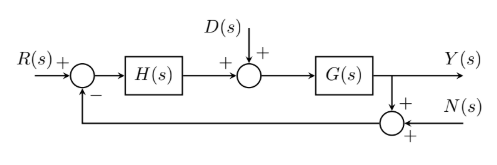

* A função de transferencia de $G(S)$ é descrita por:
\begin{equation}
G(S) = \frac{57,293}{(s+2,3)(s+4,7)(s+5,3)}
\end{equation} \\

* O sinal de referencia $R(S)$ é um degrau de amplitude 2 \\

* $H(S)$ pode ser descrito da seguinte forma no caso de um PID ideal:


 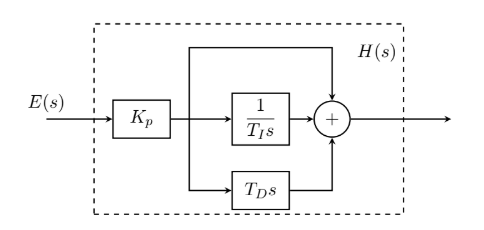

**requisitos do projeto:**
1.  Tempo de subida ($Tr$) menor que 1 segundo;
2.  Tempo de acomodação ($Ts$) menor que 7 segundos;
3.  Percentual de Overshooting ($P.O$) menor que 5%;
4.  Eliminar o erro em regime estacionário.



##Parte I (Sintonia por tentativa e erro)



### Introdução
O objetivo é modificar o lugar das raízes para que o sistema em malha fechada atenda aos requisitos desejados, ajustando os valores dos parâmetros do controlador. Para determinar um valor de 𝐾 mais adequado, analisaremos alguns índices de desempenho do sistema sem controlador para verificar se algum deles já está de acordo com os requisitos especificados, o que auxiliará para comparações futuras. Além disso, definiremos uma região que satisfaça todos os requisitos estabelecidos no início, facilitando a determinação da posição dos polos e zeros em função do ganho no gráfico de Root Locus.



#### Visão geral do sistema

In [ ]:
#Instalação da biblioteca control
!pip install control
#Importação das bibliotecas necessárias
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import inspect
from IPython.display import Image
import sympy
from scipy.optimize import fsolve

In [ ]:
# Cria a Função de Transferência em Malha Aberta
num = [57.293]
den = [1,12.3,47.91,57.293]
w = ct.tf(num,den)
print(ct.tf(num,den))
polos = ct.poles(w)
print(f'Os polos são: {polos}')

<TransferFunction>: sys[149]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


             57.29
--------------------------------
s^3 + 12.3 s^2 + 47.91 s + 57.29

Os polos são: [-5.3+0.j -4.7+0.j -2.3+0.j]


In [ ]:
# Para a nossa função temos os seguintes índices de desempenho:
def info_desempenho(w):
  # Obtendo a resposta ao degrau
  amplitude = 2  # Amplitude do degrau

  # Cálculo dos índices de desempenho
  info = ct.step_info(w,  T=np.linspace(0, 4, num=1000))
  # Ajustei o tempo final para 4s, o que coincide com o fornecido pelo Matlab, para não subestimar os valores fornecidos

  # Valores da resposta ao degrau
  tempo, resposta = ct.step_response(w)
  resposta = resposta * amplitude  # Ajuste da resposta para a nova amplitude

  # Ajustar índices para a nova amplitude
  overshoot = info['Overshoot'] * amplitude / 100  # Overshoot proporcional à nova escala
  tempo_acomodação = info['SettlingTime']  # Inalterado
  tempo_subida = info['RiseTime']  # Inalterado

  print(f"Tempo de Subida: {tempo_subida:.4f}")
  print(f"Tempo de Acomodação: {tempo_acomodação:.4f}")
  print(f"Overshooting: {overshoot}")
  print(f"Erro estacionário: {2 - resposta[-1]:.4f}")

  # resposta[-1] significa que pegamos o ultimo ponto da curva capaz de caracterizar o regime permanente

info_desempenho(w)

Tempo de Subida: 1.2292
Tempo de Acomodação: 2.2382
Overshooting: 0.0
Erro estacionário: 0.0069


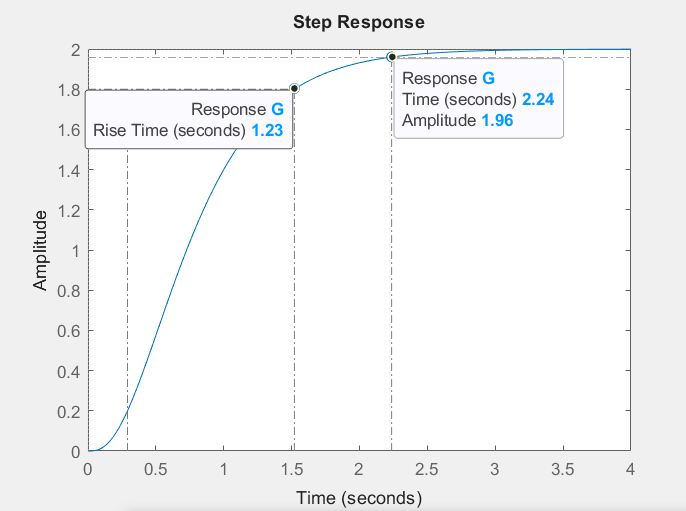

In [ ]:
Image(filename='/content/Figura 2.png')
#Imagem retirada do Matlab

**Observaçõs sobre os cálculos de índice de desempenho:**

*   Vale salientar que a amplitude da entrada não altera esses parâmetros, pois a função de transferência representa um sistema linear e invariante no tempo (LTI). Nesse caso, a dinâmica do sistema é completamente determinada pelos seus polos e zeros. Por exemplo, o tempo de acomodação para um degrau unitário ou para um degrau de amplitude 2 será o mesmo, já que representa o intervalo de tempo necessário para o sistema entrar e permanecer dentro de ±2% do valor final, independentemente da amplitude do degrau;
*   A função step_info é bem precisa, mas alguns detalhes precisam de verificação. Como exemplo temos o cálculo do tempo de acomodação, que considera o comportamento geral da resposta ao degrau, considerando o último instante de tempo em que a resposta está dentro dos 2%. Se não tivéssemos definido um intervalo máximo de tempo na função step_info como 4s a resposta para o tempo de acomodação seria 2.2525.

#### Região desejada para pertencer ao Root Locus
**Exemplo que serve para o controlador proporcional, que mantém o sistema sem zeros:**
\
A partir de uma aproximação do sistema em questão por um sistema de segunda ordem, levando em consideração os pólos dominantes(-4.7+0.j -2.3+0.j), podemos utilizar o formulário dos índices de desempenho. De modo que o lugar das raízes passe pelos pólos desejados

Os requesistos podem ser expressos da seguinte forma:
\
$\zeta = \frac{-\ln(P.O./100)}{\sqrt{\pi^2 + \ln^2(P.O./100)}}= cos(ϕ)$
\
\
$T_s = \frac{4}{\zeta \omega_n} = \frac{4}{\sigma}$
\
\
$T_r = \frac{\pi-ϕ}{\text{Wd}}$
\
\
$\omega_d = \omega_n \sqrt{1 - \zeta^2} = \sigma \tan(\phi)$
\
\
$s = -\zeta \omega_n \pm j\omega_n\sqrt{1-\zeta^2}$
\
A partir do percentual de overshoot eu encontro o valor para $\zeta$

In [ ]:
P_O = 5  #Percentual de Overshoot desejado
zeta = -np.log(P_O / 100) / np.sqrt(np.pi**2 + np.log(P_O / 100)**2)
print(f"Damping Ratio (ζ): {zeta :.4}")

phi = np.arccos(zeta) #Intervalo angular desejado
phi_graus = np.degrees(phi)
print(f'Intervalo angular desejado (phi): {phi_graus :.4}° ou {phi :.4} rad')

#Limite de Wn a partir da equação do tempo de acomodação
Wn_1 = 4/(7*zeta)

#Limite de Wn a partir da equação do tempo de subida
phi = np.arccos(zeta)
Wn_2 = (np.pi - phi)/np.sqrt(1-zeta**2)

Wn = [Wn_2, Wn_1]
Wn = max(Wn)
print(f'Frequência natural (Wn): {Wn :.4}')

sigma = Wn*zeta
print(f'Intervalo real (sigma): {sigma :.4}')

Wd = np.tan(phi)*sigma
print(f'Frequência de corte (Wd): {Wd:.4}')

Damping Ratio (ζ): 0.6901
Intervalo angular desejado (phi): 46.36° ou 0.8092 rad
Frequência natural (Wn): 3.223
Intervalo real (sigma): 2.224
Frequência de corte (Wd): 2.332


Os valores calculados estão bem próximos do que o Matlab nos fornece a partir do Rltool com a funcionalidade 'Design Requirements'. Sendo assim, precisamos escolher um valor para o ganho (K) que faça com que o Root Locus não esteja dentro da região sombreada, que foi definida como um limite a partir da imposição dos requisitos.


### I.a) Controlador P
Neste caso $H(S)$ pode ser representado considerando apenas o bloco Kp;
\
\
Com a análise inicial verificamos que é necessário buscar valores de $Kp$ para que o tempo de subida e o erro de regime estacionário atendam as especificações. Vamos verficar o que é possível fazer a partir do método do Lugar das Raízes.

Tempo de Subida: 0.67s
Tempo de Acomodação: 1.87s
Overshoot: 4.36
Erro estacionário: 1.6340
Ganho igual 0.579


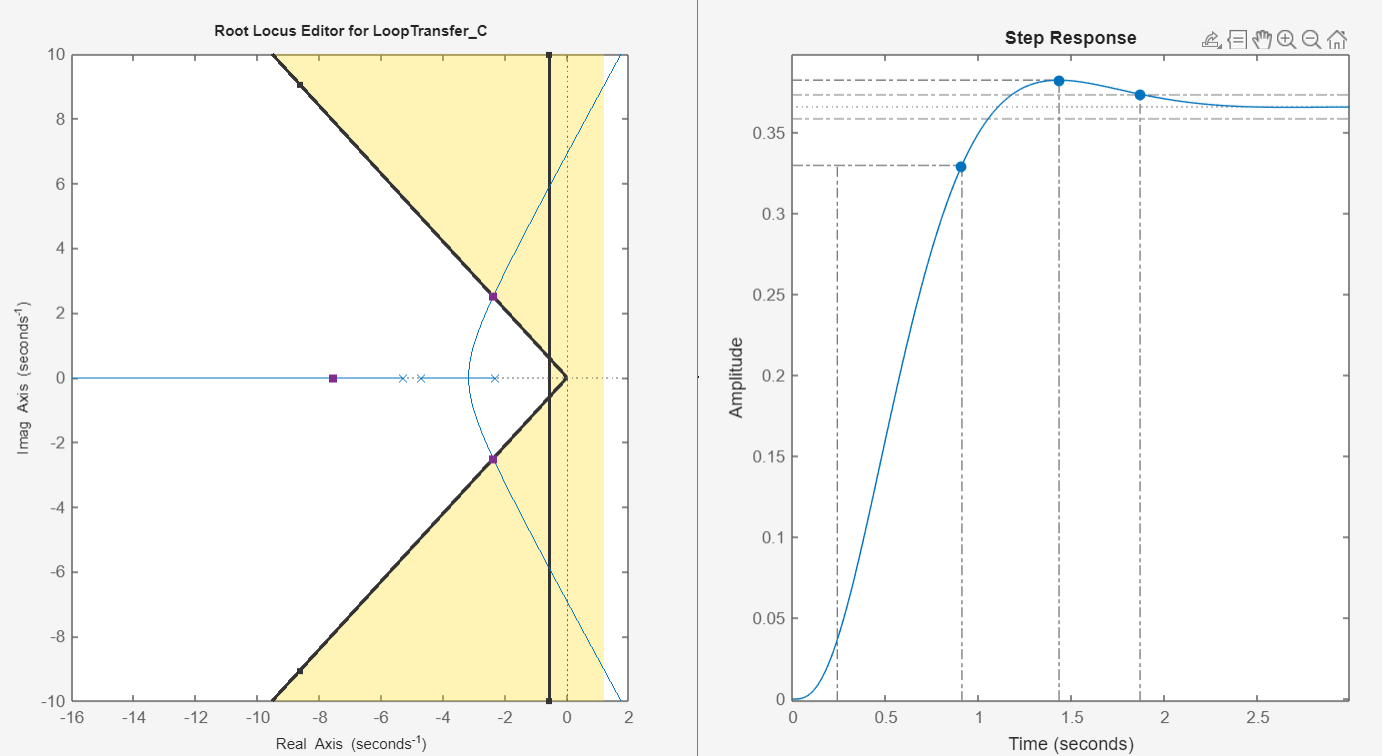

In [ ]:
print(f"Tempo de Subida: 0.67s")
print(f"Tempo de Acomodação: 1.87s")
print(f"Overshoot: 4.36")
Kc = 0.579  # Ganho definido pelo Matlab
T = ct.feedback(Kc * w)
# Resposta ao degrau
time, respost  a = ct.step_response(T)
print(f"Erro estacionário: {2 - resposta[-1]:.4f}")
print(f"Ganho igual {Kc}")
Image(filename='/content/Figura 3.png')

Foi determinado um valor de ganho que faça parte do lugar das raízes e esteja dentro da região do plano s estabelecida a partir dos requisitos.

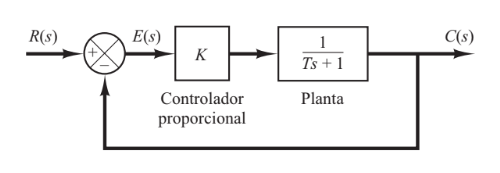

In [ ]:
Image(filename='/content/Figura 4.png')

O erro estacionário da resposta do sistema ao degrau de amplitude 2 é obtido a partir da diferença entre a amplitude da entra e a amplitude da resposta em regime estacionária, ou seja, pode ser definido como $E(s)$(indicado na figura acima). Se considerarmos que:  
\begin{equation}
\frac{E(s)}{R(s)} = \frac{R(s)-Y(s)}{R(s)} = 1- \frac{Y(s)}{R(s)}
\end{equation}
\
Lembrando que $\frac{Y(s)}{R(s)}$ é a função de transferencia do sistema em malha fechada, podemos concluir que:
\
\
\begin{equation}
\frac{E(s)}{R(s)} = 1 - \frac{G(s)H(s)}{1+G(s)H(s)} = \frac{1}{1+G(s)H(s)}
\end{equation}
Sendo G(s) a função de transferencia do sistema e H(s) o controlador proprocional, que juntos formam a função de transferencia em malha aberta.Com isso, o erro é definido como:
\begin{equation}
E(s) = \frac{R(s)}{1+G(s)H(s)}
\end{equation}
\
Se substituirmos $R(s)$ por $\frac{2}{s}$ e aplicarmos o Teorema do Valor final, já que a função $E(s)$ possui e $\frac{d}{ds} E(s)$ possuem transformada de Laplace; $E(s)$  só possui pólos no semiplano esquerdo e o limite de  $E(s)$ existe quando o tempo suficientemente longo:
\
\begin{equation}
E(s) =\lim_{s \to 0} \frac{2\cdot s}{s+s\cdot G(s)H(s)}
\end{equation}
\
\begin{equation}
E(s) =\lim_{s \to 0} \frac{2}{1+\frac{57,293\cdot Kp}{(s+2,3(s+4,7)(s+5,3)}} = \frac{2}{1+\frac{57,293\cdot Kp}{2,3 \cdot 4,7 \cdot 5,3}}
\end{equation}
\
\begin{equation}
E(s) = \frac{2}{1+Kp} = \lim_{t \to \infty} e(t)
\end{equation}
\
Isto prova que o controlador proporcional por si só não é capaz de eliminar o erro estacionário, para isto acontecer $Kp$ teria que ser um valor indeterminado (∞).Além disto, para valores pequenos de $Kp$ o desempenho em regime estacionário leva a um erro maior, como o que foi visto experimentalmente no Matlab para o ganho de 0.579.
Poderia aumentar o ganho e ainda sim estar dentro da região desejada (sombreada), mas isto implicaria em um sistema com mais oscilações, ou seja, menos estável e com um overshoot maior.



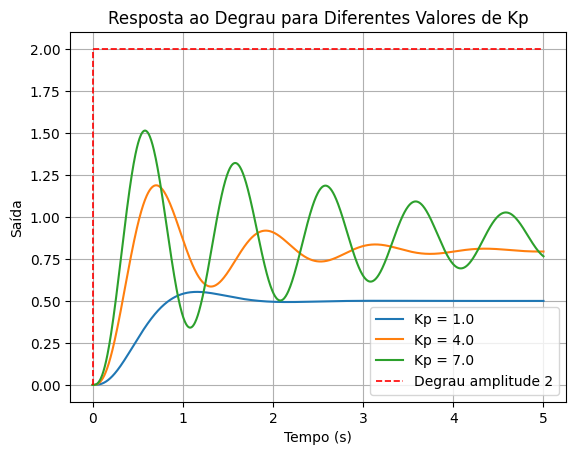

In [ ]:
# Create a single figure and axes
plt.figure()
#Parametros
Tempo= np.linspace(0, 5, num=1000)
# Plotando a resposta ao degrau para diferente valores de ganho
for Kp in np.arange(1, 10, 3):
    T = ct.feedback(Kp * w)
    tempo, resposta = ct.step_response(T,Tempo)
    plt.plot(tempo, resposta, label=f"Kp = {Kp:.1f}")

# Plotando o degrau de entrada
plt.plot(np.linspace(0, 5, num=1000), 2 * np.ones_like(Tempo),
         color="r", linestyle="--", linewidth=1.2, label='Degrau amplitude 2')
plt.vlines(x=0, ymin=0, ymax=2, colors='r', linestyles='--', linewidth=1.2)

# Adicionando legendas e títulos
plt.title("Resposta ao Degrau para Diferentes Valores de Kp")
plt.xlabel("Tempo (s)")
plt.ylabel("Saída")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

Constata-se a afirmativa final anterior, que conforme o ganho aumenta o overshoot aumenta, ainda que o tempo de subida diminua.

### I.b) Controlador PI
Neste caso $H(s)$ é representado a partir dos blocos $K_p$ e $\frac{1}{Ti ⋅ s}$, adicionando um pólo na origem e um zero.
\
\
\begin{equation}
H(s) ⋅ G(s) = K_p ⋅\frac{T_i⋅s+1}{T_i⋅s}⋅G(s) = \frac{57,293 ⋅(s+z)}{(s+2,3)(s+4,7)(s+5,3)}
\end{equation} \\
Ao redesenhar o lugar das raízes com o novo pólo e zero, temos:


Tempo de Subida: 1.02s
Tempo de Acomodação: 2.73s
Overshoot: 3.67
Constante de tempo do integrador: 0.4694835680751174
Erro estacionário: 0.0002
Ganho igual 1.27


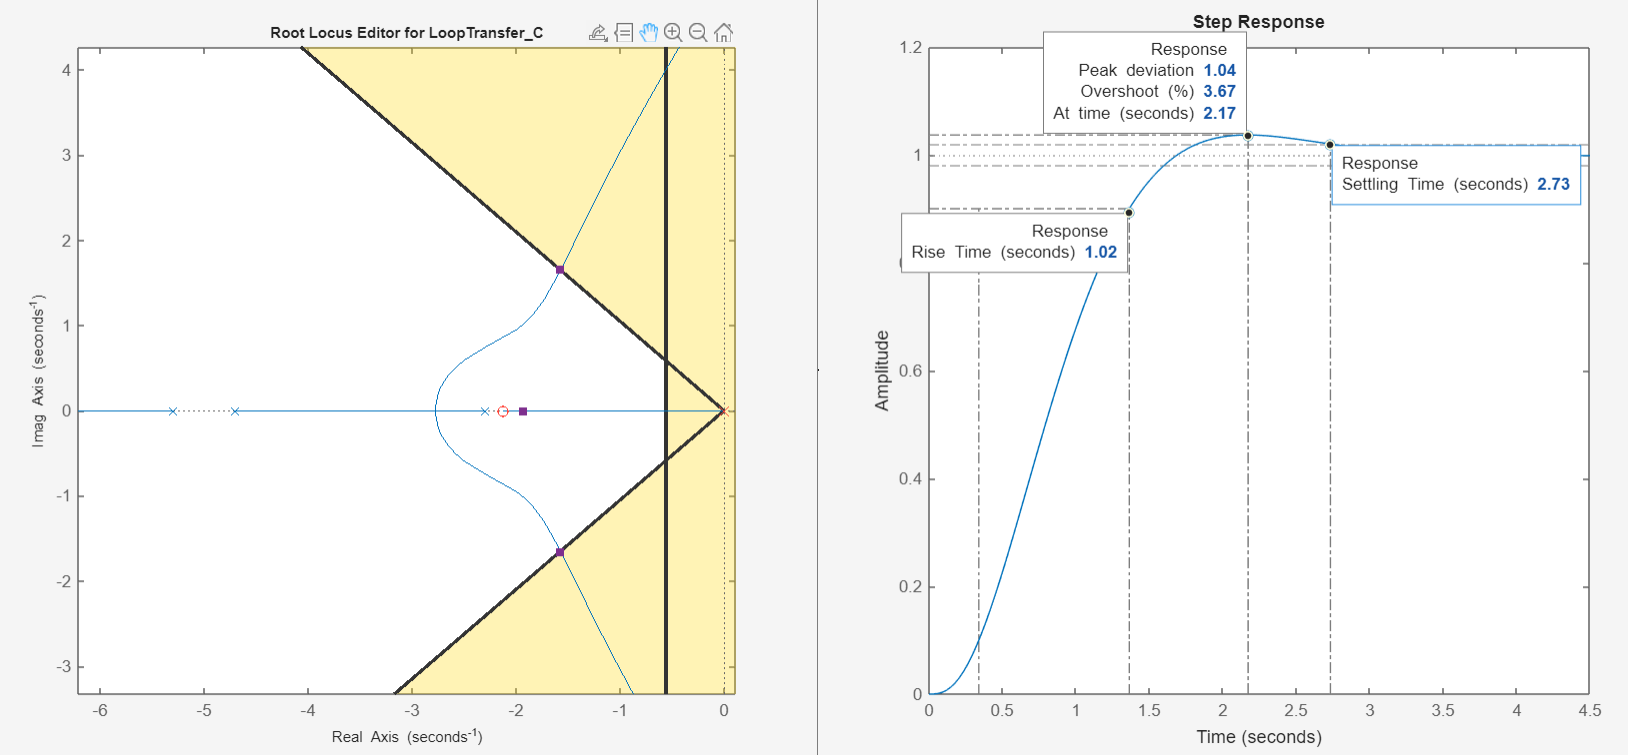

In [ ]:
print(f"Tempo de Subida: 1.02s")
print(f"Tempo de Acomodação: 2.73s")
print(f"Overshoot: 3.67")
Kp = 1.27  # Ganho definido pelo Matlab
z = -2.13 # Posição do zero adicional
tau = -(1/z) # Constante de tempo do integrador
print(f"Constante de tempo do integrador: {tau}")
num = [57.293,57.293*2.13]
den = [1,12.3,47.91,57.293,0]
w_2 = ct.tf(num,den)
T = ct.feedback(Kp* w_2)
# Resposta ao degrau
time, resposta = ct.step_response(T)
print(f"Erro estacionário: {1 - resposta[-1]:.4f}")
print(f"Ganho igual {Kp}")
Image(filename='/content/Figura 5.png')

**Impactos da adição de um pólo na origem:**


*  Aumento do ganho do sistema, eliminando o erro de regime permanente;

*  O polo na origem tende a deslocar os polos dominantes em direção ao eixo imaginário no plano 𝑠. Isso diminui a frequência natural do sistema, que está diretamente relacionada ao tempo de resposta, tornando a resposta mais lenta.

**Impactos da adição de um zero em -2.13:**


*   Ajuda a compensar a lentidão causada pelo pólo na origem, reduzindo o tempo de subida e o tempo de acomodação;
*   Quanto mais afastado do eixo imaginário o zero estiver (mais à esquerda no plano 𝑠, menor será o overshoot. Isso ocorre porque o zero atrai os ramos do Root Locus para regiões mais estáveis, melhorando a estabilidade relativa do sistema.



### I.c) Controlador PID
Neste caso $H(s)$ é representado a partir dos blocos $K_p$, $\frac{1}{T_i ⋅ s}$ e $T_d ⋅s$, adicionando um pólo na origem e dois zeros.

$$H(s) = \frac{K_p}{T_i ⋅s}+K_p ⋅ T_d ⋅s+K_p =K_p ⋅( \frac{1}{T_i ⋅s}+ T_d ⋅s + 1)$$
\
$$H(s)= \frac{K_p}{T_i ⋅s} ⋅(T_d ⋅T_i⋅s^2 + T_i ⋅s+1)= \frac{K_p}{T_i ⋅s}⋅(s+Z_1)(s+Z_2) $$
\
Sendo:
$Z_1= \frac{-T_i + \sqrt{T_i^2 - 4⋅T_i⋅T_d}}{2 \cdot T_i ⋅T_d}$ e $Z_2= \frac{-T_i - \sqrt{T_i^2 - 4⋅T_i⋅T_d}}{2 \cdot T_i ⋅T_d}$
\
Ao redesenhar o lugar das raízes com o novo pólo e os novos zeros, temos:





Tempo de Subida: 0.871s
Tempo de Acomodação: 1.37s
Overshoot: 0.075
Constante de tempo do integrador: 0.6526342280528955
Constante de tempo do derivador: 0.09341429238673517
Ganho proporcional: 1.0637937917262197
Erro estacionário: 0.0008


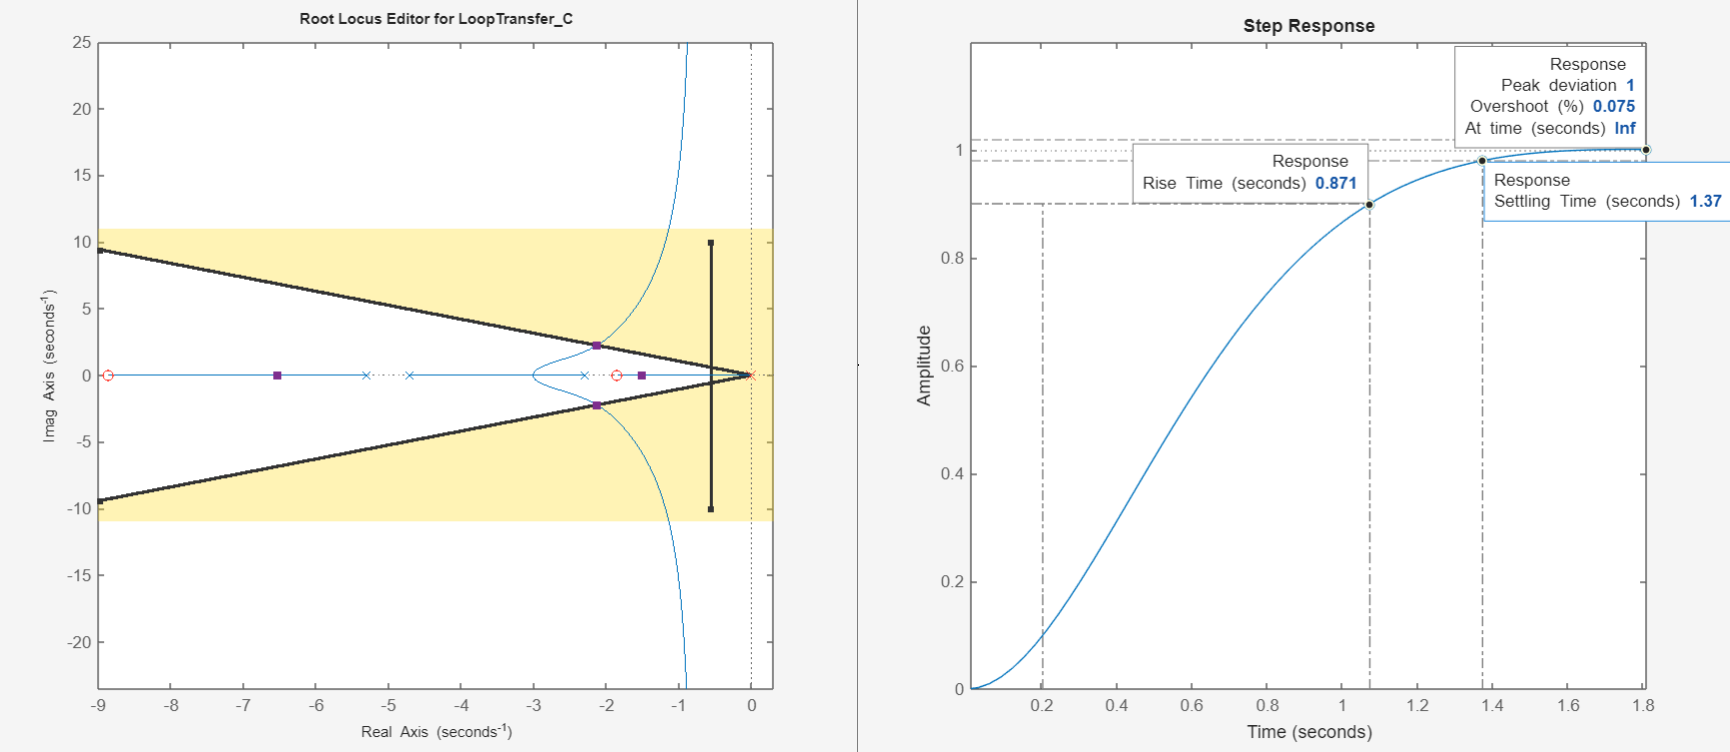

In [ ]:
print(f"Tempo de Subida: 0.871s")
print(f"Tempo de Acomodação: 1.37s")
print(f"Overshoot: 0.075")
Kc = 1.63  # Ganho definido pelo Matlab
z1 = -1.853 # Posição do primeiro zero adicional
z2 = -8.852 # Posição do segundo zero adicional
#Descobrindo as constantes de tempo do bloco integrador e derivador

# Define as variáveis simbólicas
Ti, Td = sympy.symbols('Ti Td')

# Define as equações
eq1 = sympy.Eq(z1 * 2 * Ti * Td, -Ti + sympy.sqrt(Ti**2 - 4 * Ti * Td))
eq2 = sympy.Eq(z2 * 2 * Ti * Td, -Ti - sympy.sqrt(Ti**2 - 4 * Ti * Td))

# Resolve o sistema de equações
soluçao = sympy.solve([eq1, eq2], (Ti, Td), dict=True)

# Extrai os valores das constantes de tempo
tau_i = float(soluçao[1][Ti])
tau_d = float(soluçao[1][Td])

print(f"Constante de tempo do integrador: {tau_i}")
print(f"Constante de tempo do derivador: {tau_d}")

# Cálculo do ganho proporcional
Kp = Kc * tau_i
print(f"Ganho proporcional: {Kp}")

# Cálculo para o erro em regime permanente
num = [57.293*Kp*tau_i*tau_d,57.293*Kp*tau_i,57.293*Kp]
den = [1,12.3,47.91,57.293,0]
w_2 = ct.tf(num,den)
T = ct.feedback(w_2)

# Resposta ao degrau
time, resposta = ct.step_response(T)
print(f"Erro estacionário: {1 - resposta[-1]:.4f}")
Image(filename='/content/Figura 6.png')

Ao usarmos os 3 blocos para a função de transferencia do controlador, concluimos que :


*   Ação derivativa influencia diretamente no amortecimento (o percentual de overshoot sem o bloco derivativo era 3.67 e passou a ser 0.075);
*   Ação integral influencia diretamente na diminuição do erro em regime permanente;
*   Ação proporcional influencia na velocidade da resposta, já que a posição dos polos do sistema em malha fechada depende de $K_p$.




###I.d) Ajuste fino
Não foi necessário realizar um ajuste fino dos parametros de $H(s)$, pois em todos os casos existia um valor de ganho que o pólo do controlador coincidia com o pólo desejado, ou seja, o lugar das raízes passava pelo pólo desejado.

###I.e)
Para introduzir um ruído utilizei um ruído branco presente no simulink (Band-limited White Noise), com os seguintes parametros ajustados:


*   **Noise Power**: Define a potencia do ruído. Foi ajustado para 0.005 $W$/$Hz$;
*   **Sample Time** : Tempo de amostragem do sinal de ruído. Mantive o padrão de 0.1s;
*   **Seed**: Define a semente para o gerador de números aleatórios, garantindo a reprodutibilidade do sinal de ruído. Mantive o padrão de 23341.



#### Controlador P

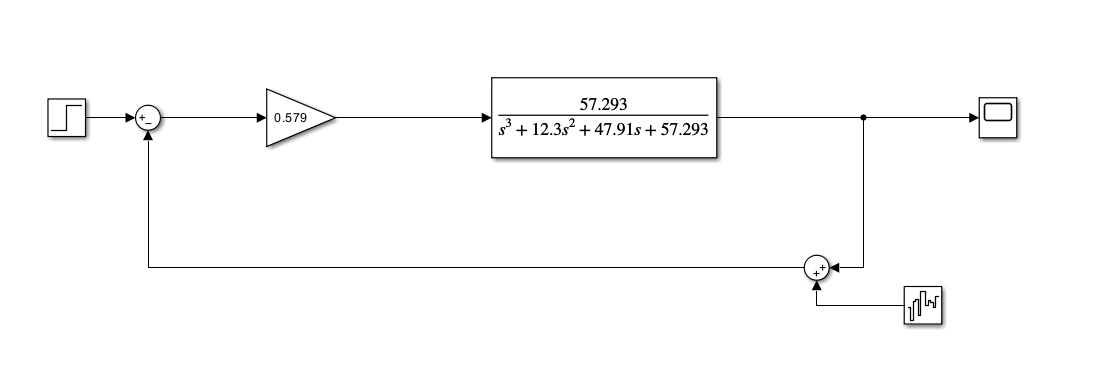

In [ ]:
image_path = '/content/Figura 8.png'
image1 = Image(filename=image_path)
image1


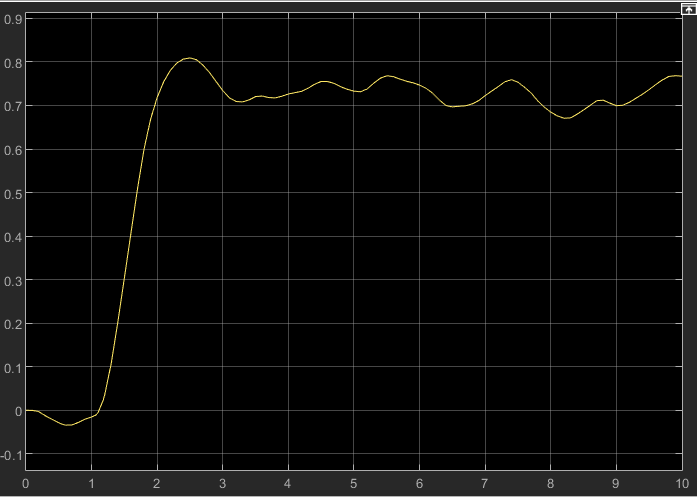

In [ ]:
image_path_2 = '/content/Figura 8.1.png'
image2 = Image(filename=image_path_2)
image2

#### Controlador PI

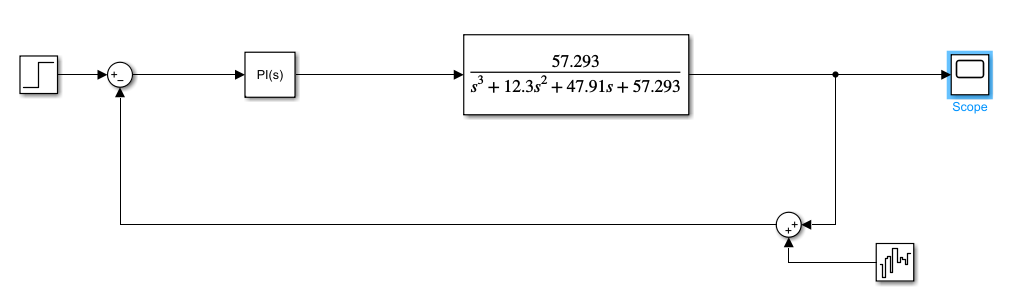

In [ ]:
Image(filename='/content/Figura 9.1.png')


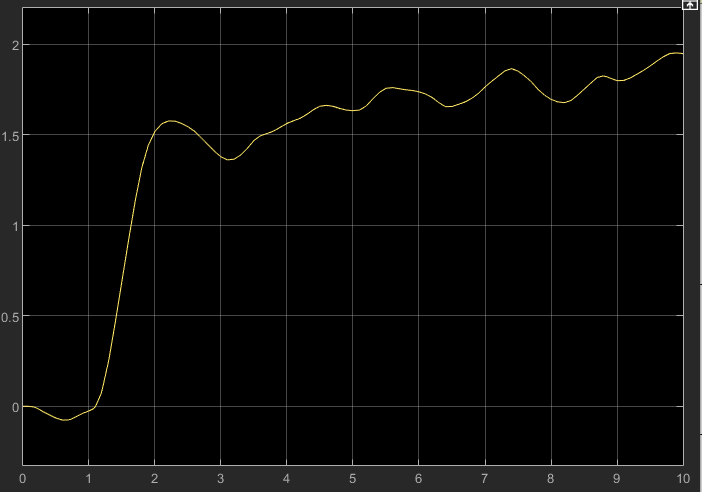

In [ ]:
Image(filename = '/content/Figura 9.png')

#### Controlador PID

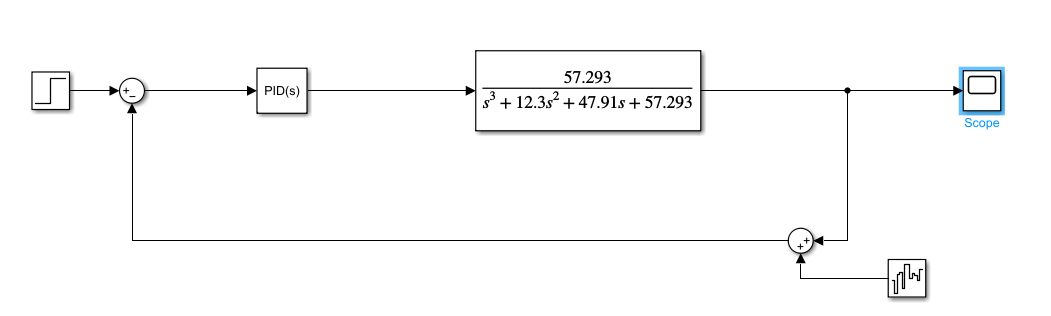

In [ ]:
Image(filename='/content/Figura 10.png')

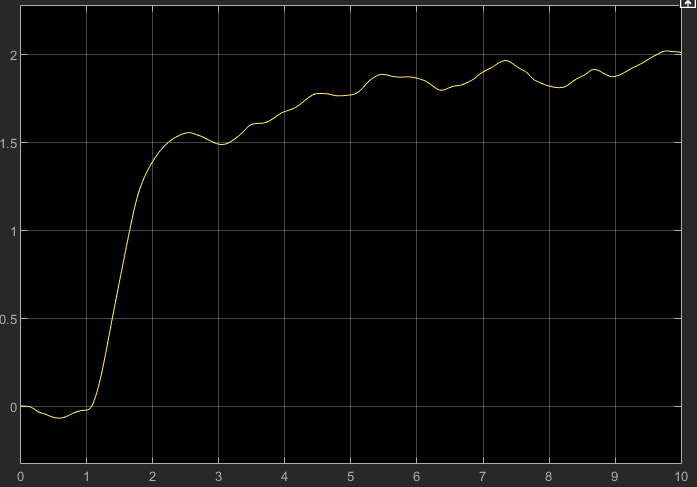

In [ ]:
Image(filename='/content/Figura 10.1.png')

#### Conclusões
Verifica-se ao adicionar uma ação derivativa aumentamos o amortecimento, ou seja, as oscilações apresentaram amplitudes menores. A ação do integrador permitiu diminuir o erro em regime permanente, já que só com a ação proporcional a saída não conseguia alcançar a amplitude da entrada. Por fim, em relação a ação proporcional, já que o $K_p$ é menor do que 1 não houve amplificação do ruído, e sim uma redução.

###I.f)
Um distúrbio é uma segunda entrada adicionada ao sitema, por isso escolhi uma entrada degrau unitário.

#### Controlador P

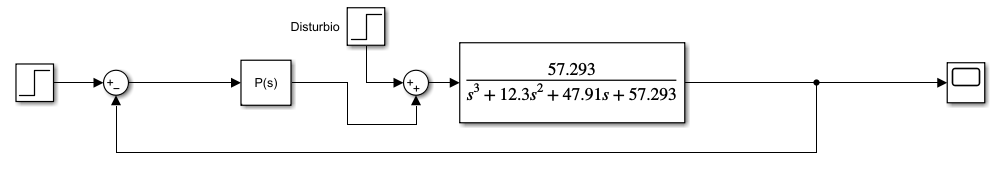

In [ ]:
Image(filename='/content/Figura 13.png')

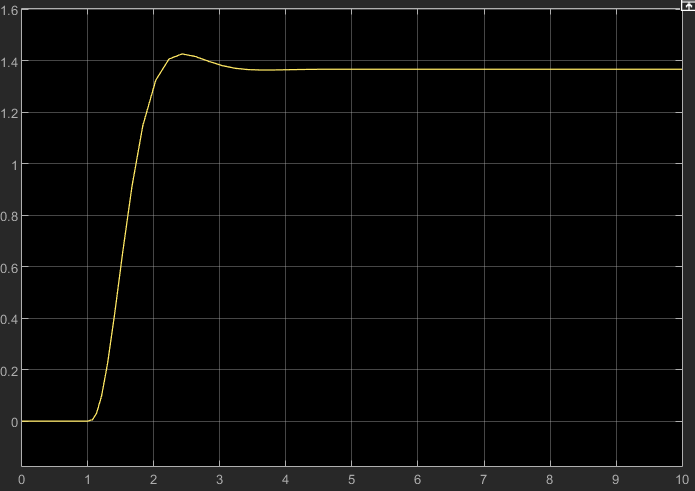

In [ ]:
Image(filename='/content/Figura 13.1.png')

#### Controlado PI

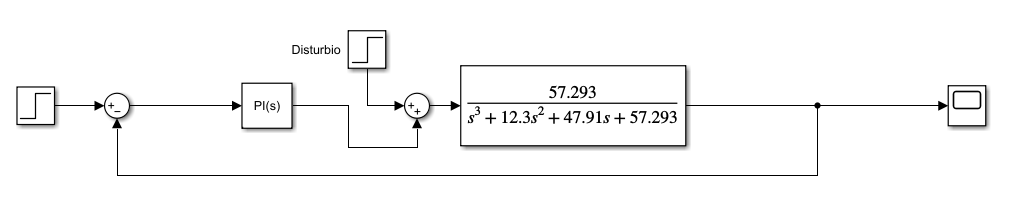

In [ ]:
Image(filename='/content/Figura 12.1.png')

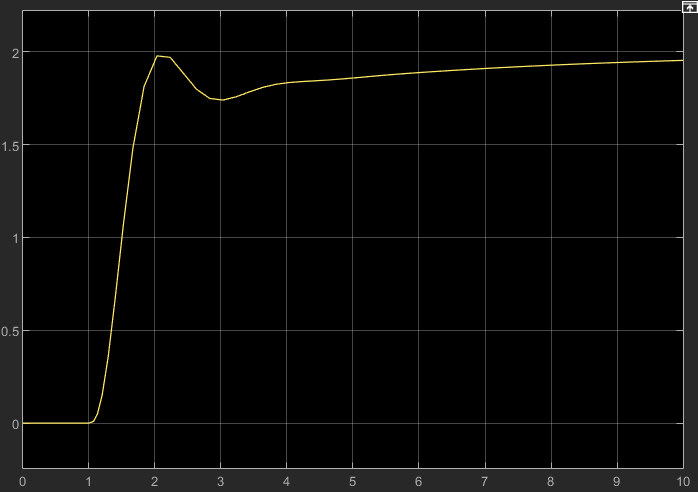

In [ ]:
Image(filename='/content/Figura 12.png')

#### Controlador PID

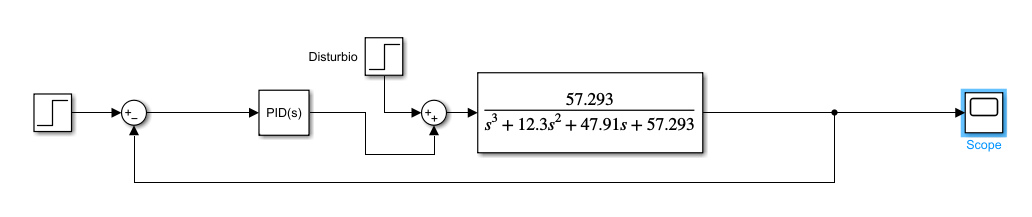

In [ ]:
Image(filename='/content/Figura 11.png')

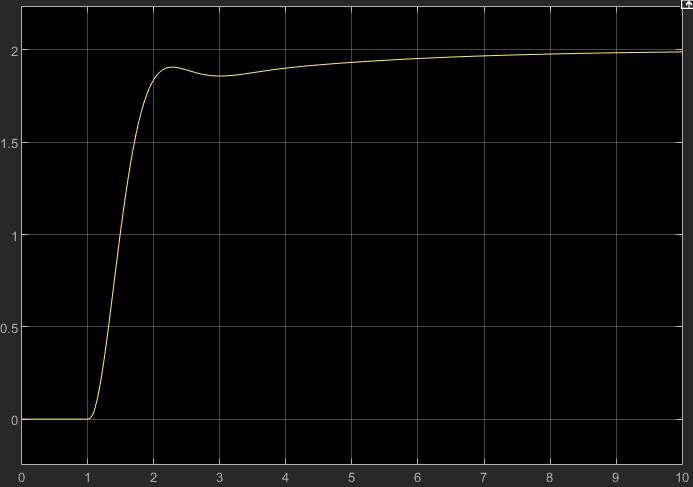

In [ ]:
Image(filename='/content/Figura 11.1.png')

#### Conclusões
O controlador proporcional com a presença de um distúrbio reagiu aumentando a sua amplitude da saída, chegando mais próximo da amplite 2, mas não mudou a forma da resposta;
Verifica-se que o controlador proporcional integrativo tentou rejeitar o distúrbio, mas isso implicou em uma pequena oscilação. Esta oscilação foi quase completamente extinguida com a ação derivativa introduzida pelo controlador PID.

## Parte 2 (Sintonia por Ziegler-Nichols)

In [ ]:
def ponto_inflexao(w, magnitude_degrau):
  # Obtém a resposta ao degrau
  tempo, resposta = ct.step_response(w)

  # Calcula a segunda derivada
  segunda_derivada = np.gradient(np.gradient(resposta, tempo), tempo)

  # Encontra o índice do ponto de inflexão, igualando a segunda derivada a zero
  indice_inflexao = np.where(np.diff(np.sign(segunda_derivada)))[0][0]

  # Obtém o tempo e valor da resposta no ponto de inflexão
  tempo_inflexao = tempo[indice_inflexao]
  resposta_inflexao = resposta[indice_inflexao]

  # Encontra o índice do tempo de inflexão no array 'tempo'
  indice_inflexao = np.abs(tempo - tempo_inflexao).argmin()

  # Calcula a derivada no ponto de inflexão
  alfa = np.gradient(resposta, tempo)[indice_inflexao]
  alfa = alfa / magnitude_degrau

  # Calculo do atraso
  b = resposta_inflexao - alfa*tempo_inflexao
  atraso = b/alfa

  print(f"Ponto de inflexão: Tempo = {tempo_inflexao:.4f}s, Resposta = {resposta_inflexao:.4f}")
  print(f"Coeficiente angular da reta: {alfa:.4f}")
  print(f"Atraso: {atraso:.4f}")

  # Evidenciando o indice no grafico
  plt.figure(figsize=(10, 6))
  plt.plot(tempo, resposta, label='Resposta ao Degrau')
  plt.plot(tempo[indice_inflexao], resposta[indice_inflexao], 'ro', label='Ponto de Inflexão')
  plt.xlabel('Tempo (s)')
  plt.ylabel('Resposta')
  plt.title('Resposta ao Degrau e Ponto de Inflexão')
  plt.legend()
  plt.grid(True)
  plt.show()
  return tempo_inflexao, resposta_inflexao, alfa, b, atraso

###II.a)


Ponto de inflexão: Tempo = 0.5178s, Resposta = 0.3049
Coeficiente angular da reta: 0.4871
Atraso: 0.1082


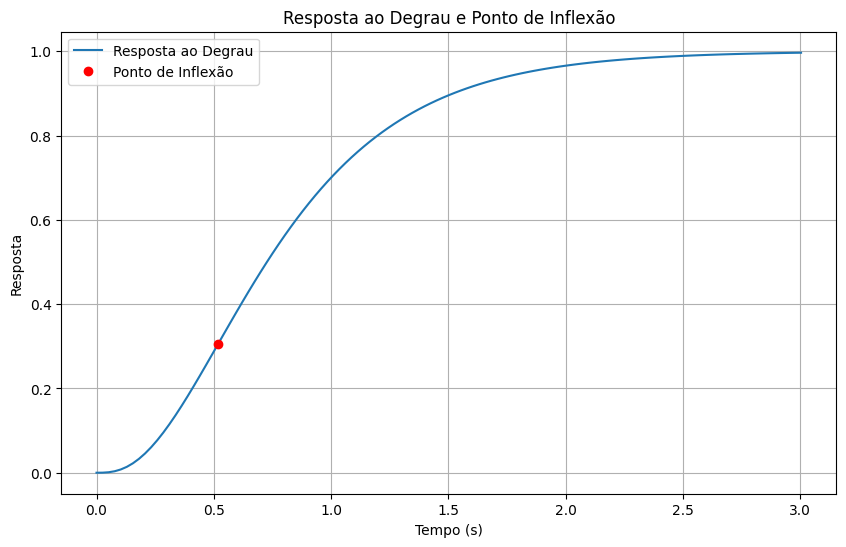

In [ ]:
num = [57.293]
den = [1, 12.3, 47.91, 57.293]
w = ct.tf(num, den)
p=ponto_inflexao(w,2)

In [ ]:
#Usando as recomendações de Ziegler-Nichols para encontrar os parametros do controlador
Kp= 1/p[3]
print(f'Ganho proporcional: {Kp:.4}')
print('Constante de tempo do integrador: tende ao infinito')
print('Constante de tempo do derivador: igual a zero')

Ganho proporcional: 18.98
Constante de tempo do integrador: tende ao infinito
Constante de tempo do derivador: igual a zero


###II.b)


Ponto de inflexão: Tempo = 15.6566s, Resposta = 14.8203
Coeficiente angular da reta: 0.5000
Atraso: 13.9841


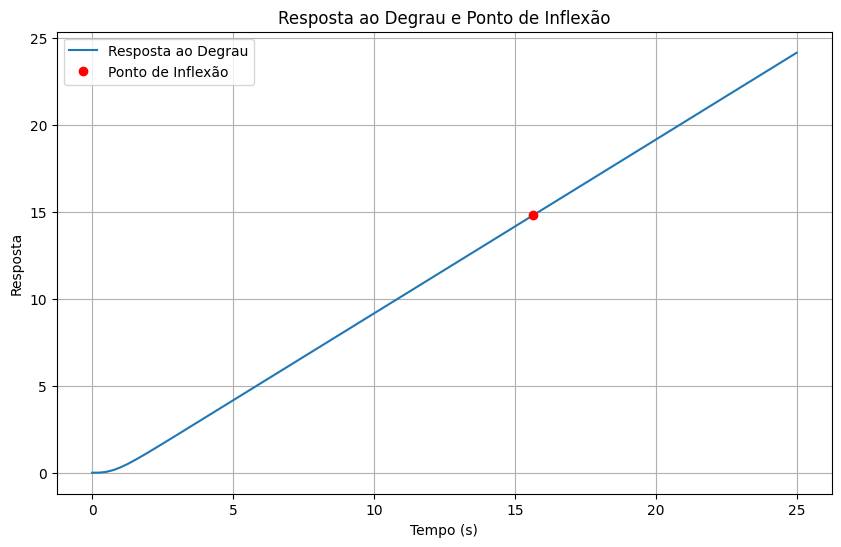

In [ ]:
num = [57.293]
den = [1, 12.3, 47.91, 57.293,0]
w = ct.tf(num, den)
pi=ponto_inflexao(w,2)

In [ ]:
#Usando as recomendações de Ziegler-Nichols para encontrar os parametros do controlador
Kp= 0.9/pi[3]
Ti= pi[4]/0.3
print(f'Ganho proporcional: {Kp:.4}')
print(f'Constante de tempo do integrador: {Ti:.4}')
print('Constante de tempo do derivador: igual a zero')

Ganho proporcional: 0.1287
Constante de tempo do integrador: 46.61
Constante de tempo do derivador: igual a zero


###II.c)

Ponto de inflexão: Tempo = 0.2525s, Resposta = 1.4384
Coeficiente angular da reta: 4.0784
Atraso: 0.1002


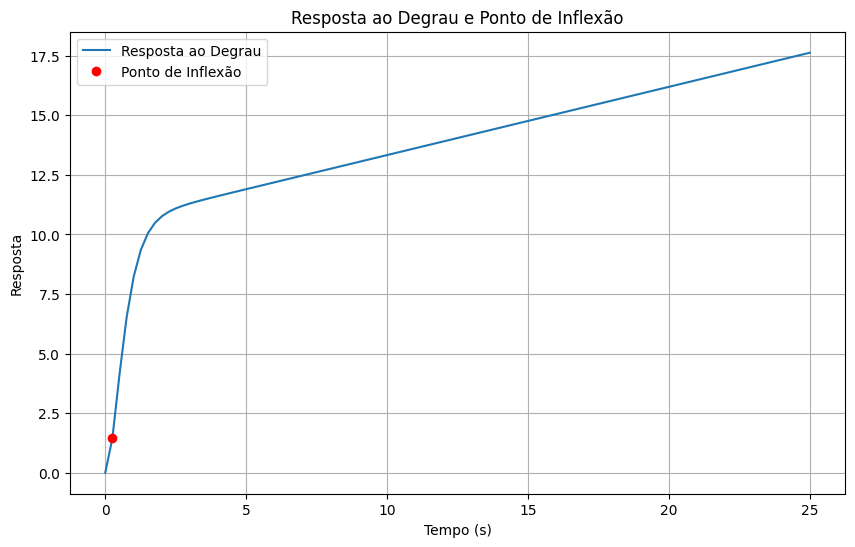

In [ ]:
z1 = -1.853 # Posição do primeiro zero adicional
z2 = -8.852 # Posição do segundo zero adicional
num = [57.293,57.293*(-z1-z2),-z1*-z2]
den = [1, 12.3, 47.91, 57.293,0]
w = ct.tf(num, den)
pid=ponto_inflexao(w,2)

In [ ]:
#Usando as recomendações de Ziegler-Nichols para encontrar os parametros do controlador
Kp= 2/pi[3]
Ti= pi[4]/0.5
Td= 0.5*pi[4]
print(f'Ganho proporcional: {Kp:.4}')
print(f'Constante de tempo do integrador: {Ti:.4}')
print(f'Constante de tempo do derivador: {Td:.4}')

Ganho proporcional: 0.286
Constante de tempo do integrador: 27.97
Constante de tempo do derivador: 6.992


###II.d)
Verifica-se valores de ganhos bem distintos, isto pode ser justificável apenas por inspeção visual, pois a partir da resposta ao degrau verifica-se que o fator de incontrolabilidade é menor que o limite inferior permitido. Neste caso, o ganho mais confiável é o obtido na parte I.
Obs: o fator de incontrolabilidade é um relação entre o tempo morto e tempo necessário para que a resposta alcançe o valor de 2 com uma velocidade determinanda a partir da derivada no ponto de inflexão.

### II.e)
Verica-se que pelo método de tentativa e erro o ganho proporcional foi maior, o que promove um reação mais rápida do sistema. Já em relação a contante de tempo do integrador o método de Ziegler-Nichols foi maior, isso significa uma ação integral mais lenta, ou seja, maior tempo de resposta.

### II.f)
O método de Ziegler-Nichols apresenta um fator de incontrolabilidade aproximadamente igual zero, já que o tempo morto é aproximadamente zero. Logo concluimos que não é possível comparar os dois métodos, pois o método de Ziegler-Nichols não é válido para este caso, logo o método por tentativa e erro que permanece como o mais correto.

### II.g)
Na presença de distúrbios é mais difícil encontrar o ponto de inflexão e gera um tempo de atraso(L) significantemente baixo, o que pode tornar a resposta do controlador mais agressiva, ou seja, ganho proporcional e intregativo altos.

## Parte 3 (Sintonia por alocação e cancelamento de polos)

###III.a)
\begin{equation}
G(S) = \frac{57,293}{(s-2,3)(s+4,7)(s+5,3)}
\end{equation} \\

**Objetivo:** Projetar um controlador ($H(s)$) que cancele o pólo instável de $G(s)$ e faça com que o tempo de subida ($Tr$) do sistema seja em torno de 1 segundo e o tempo de acomodação ($Ts$) em torno de 5
segundos, ou seja:
\
\
$T_s = \frac{4}{\zeta \omega_n} = \frac{4}{\sigma} \leq 5$
\
\
$T_r = \frac{\pi-ϕ}{\text{Wd}}\leq 1$
\
\
Para cancelar o pólo instável eu preciso adicionar um zero no sistema, que faça com que o Root Locus passe por um ponto desejado, um ponto que atende a todos os requisitos.

$\frac{T_s}{T_r} = \frac{4}{\zeta \omega_n}⋅\frac{\omega_n \sqrt{1 - \zeta^2}}{\pi-ϕ}= \frac{4 \cdot \sqrt{1 - \zeta^2}}{\zeta ⋅(\pi-\arccos{\zeta})} = 5 $

In [ ]:
sigma = 4/5
print(f'Intervalo real (sigma): {sigma :.4}')

def equação_zeta(zeta):
    return 4 * np.sqrt(1 - zeta**2) / (zeta * (np.pi - np.arccos(zeta))) - 5

solução_zeta = fsolve(equação_zeta, 0.5)  # Chute inicial de 0.5
print(f"O valor de zeta é: {solução_zeta[0]:.4f}")

phi = np.arccos(solução_zeta[0]) #Intervalo angular desejado
phi_graus = np.degrees(phi)
print(f'Intervalo angular desejado (phi): {phi_graus :.4}° ou {phi :.4} rad')

Wn = sigma/solução_zeta[0]
print(f'Frequência natural (Wn): {Wn :.4}')

Wd = np.tan(phi)*sigma
print(f'Frequência de corte (Wd): {Wd:.4}')

polo_desejado = complex(sigma, Wd)
print(f'Polo desejado: {complex(-sigma, Wd)}')

Intervalo real (sigma): 0.8
O valor de zeta é: 0.3781
Intervalo angular desejado (phi): 67.78° ou 1.183 rad
Frequência natural (Wn): 2.116
Frequência de corte (Wd): 1.959
Polo desejado: (-0.8+1.9585747154870328j)


<TransferFunction>: sys[27]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


            57.29
------------------------------
s^3 + 7.7 s^2 + 1.91 s - 57.29



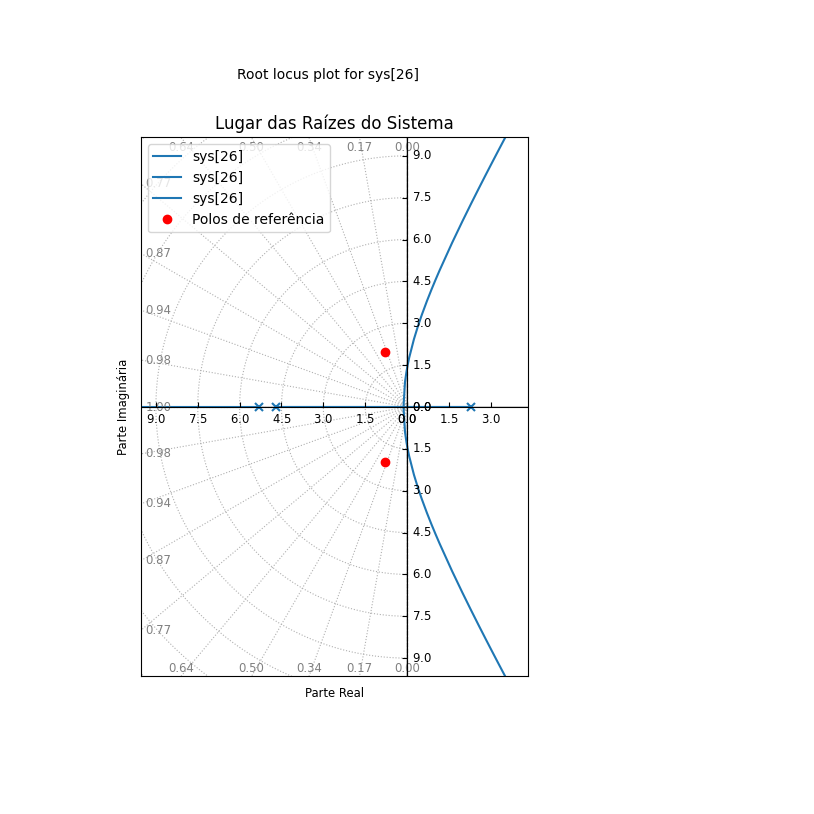

In [ ]:
# Nova função de transferencia
num = [57.293]
den = [1,7.7,1.91,-57.293]
w_2 = ct.tf(num,den)
print(ct.tf(num,den))
# Plot do lugar das raízes
plt.figure(figsize=(5, 7))
ct.rlocus(w_2, grid=True)
plt.title("Lugar das Raízes do Sistema")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginária")
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8)  # Linha do eixo imaginário

# Adiciona os polos de referência ao gráfico
polo_1 = complex(-sigma, Wd)
polo_2 = complex(-sigma, -Wd)
plt.plot([polo_1.real, polo_2.real], [polo_1.imag, polo_2.imag], 'ro', label="Polos de referência")
plt.legend()
plt.show()

Através do gráfico de Root Locus é notório a necessidade da adição de u zero real, de modo que o gráfico tenda para a esquerda. Este efeito será visto com mais impacto se o zero for adicionado mais próximo do pólo dominante (pólo com parte real positiva).
\
\
Então, o numerador da nossa função de transferencia de malha aberta após adicionar o bloco do controlador PD será:\
$$K_p(T_d s + 1) = K_p ⋅T_d(s + \frac{1}{T_d})$$
\
O -$\frac{1}{T_d}$ será o nosso novo zero adicionado ao sistema. Agora para saber qual terá que ser o valor do novo zero para que o gráfico de Root Locus passe pelo ponto desejado vamos aplicar a condição de angulo. Desse modo, a soma de todos os angulos que os polos e zeros fazem com um ponto de teste deve ser igual a um multiplo ímpar de 180°. Obs: Se a função de transferencia do sistema de malha fechada é
$\frac{G(s)⋅H(s)}{1+G(s)⋅H(s)}$, a equação característica deverá ser:
\
\
$1+ G(s)⋅H(s) = 0$, de modo que exista um pólo complexo que satisfaça $G(s)⋅H(s) = L(s) = -1$. Isto só acontece se $arg(L(s))=-180°$ e $\lvert L(s)\rvert = 1$. Por isso podemos realizar os seguintes passos:
\
\
ϕ(s+$\frac{1}{T_d}$)-ϕ(s-2.3)-ϕ(s+4.7)-ϕ(s+5.7) = 180.(2k+1) , sendo k={0,1,2,3,...}

Subistituindo s pelo ponto desejado:\
ϕ(-0.8+1.958j+$\frac{1}{T_d}$)-ϕ(-0.8+1.958j-2.3)-ϕ(-0.8+1.958j+4.7)-ϕ(-0.8+1.958j+5.7) = 180.(2k+1)
\
\
ϕ(-0.8+1.958j+$\frac{1}{T_d}$)-147.72°-26.65°-21.78° = 180
\
\
ϕ(-0.8+1.958j+$\frac{1}{T_d}$)= 180° + 196.15°
\
\
$\frac{1.958}{-0.8+\frac{1}{T_d}} = \tan(376.15°) = 0.289$
\
\
$\frac{-1}{T_d} = Z1$ = -7.5

Para definir o ganho, vamos calculá-lo a partir da condição de módulo:
$$\lvert \frac{57.293k(s+15.842)}{(s-2.3)(s+4.7)(s+5.3)} \rvert=1$$
\
$$\lvert \frac{(s-2.3)(s+4.7)(s+5.3)}{57.293(s+z)} \rvert=k$$
\
Substituindo s por -0.8 + 1.958j:
\
\
$$\lvert \frac{(-3.1+1.958j)(3.9+1.958j)(4.5+1.958j)}{57.293(15.042+1.958j)} \rvert=k$$



In [ ]:
num_1 = -3.1+1.98j
num_2= 3.9+1.98j
num_3= 4.5+1.98j
den = 57.293
k = abs(num_1*num_2*num_3/den)
k

1.380567669145673

Por fim, encontramos um ganho de aproximadamente 1.38.
\
Analisando a posição dos pólos no Root Locus para este ganho e a resposta ao degrau, temos:


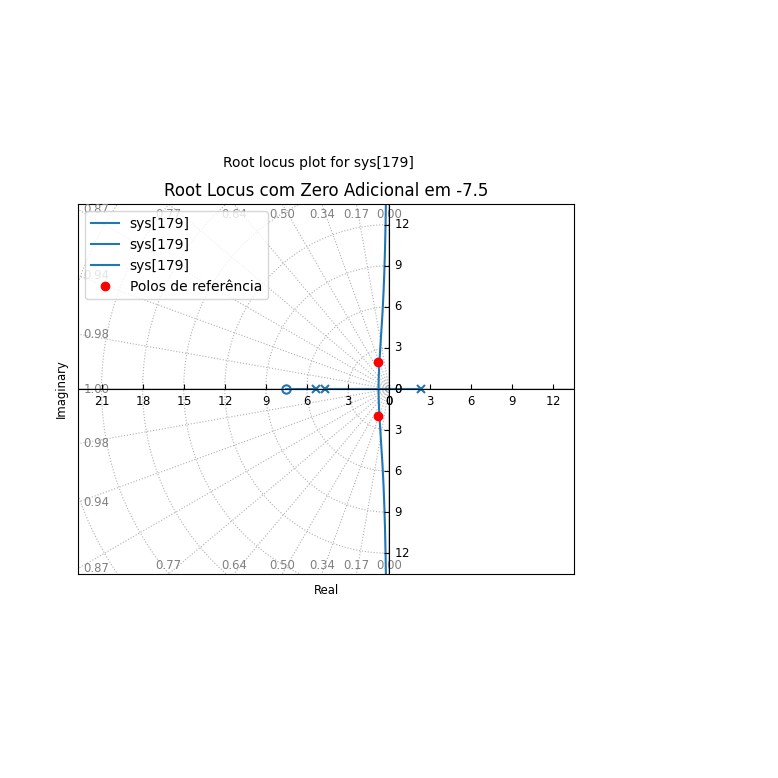

In [ ]:
# função de transferência original
num = [57.293]
den = [1, 7.7, 1.91, -57.293]
G = ct.tf(num, den)

# Adiciona um zero em -7.5
G_zero = ct.tf([1, 7.5], 1)  # Função de transferência para o zero
G_nova = G * G_zero  # Função de transferência com o zero adicional


# Plota o root locus
plt.figure()
ct.root_locus(G_nova)
plt.title('Root Locus com Zero Adicional em -7.5')

# Resposta ao degrau
time, response = ct.step_response(G_nova)

# Adiciona os polos de referência ao gráfico
polo_1 = complex(-sigma, Wd)
polo_2 = complex(-sigma, -Wd)
plt.plot([polo_1.real, polo_2.real], [polo_1.imag, polo_2.imag], 'ro', label="Polos de referência")
plt.legend()
plt.show()

Tempo de Subida: 0.929s
Tempo de Acomodação: 5.07s
Ganho: 1.3


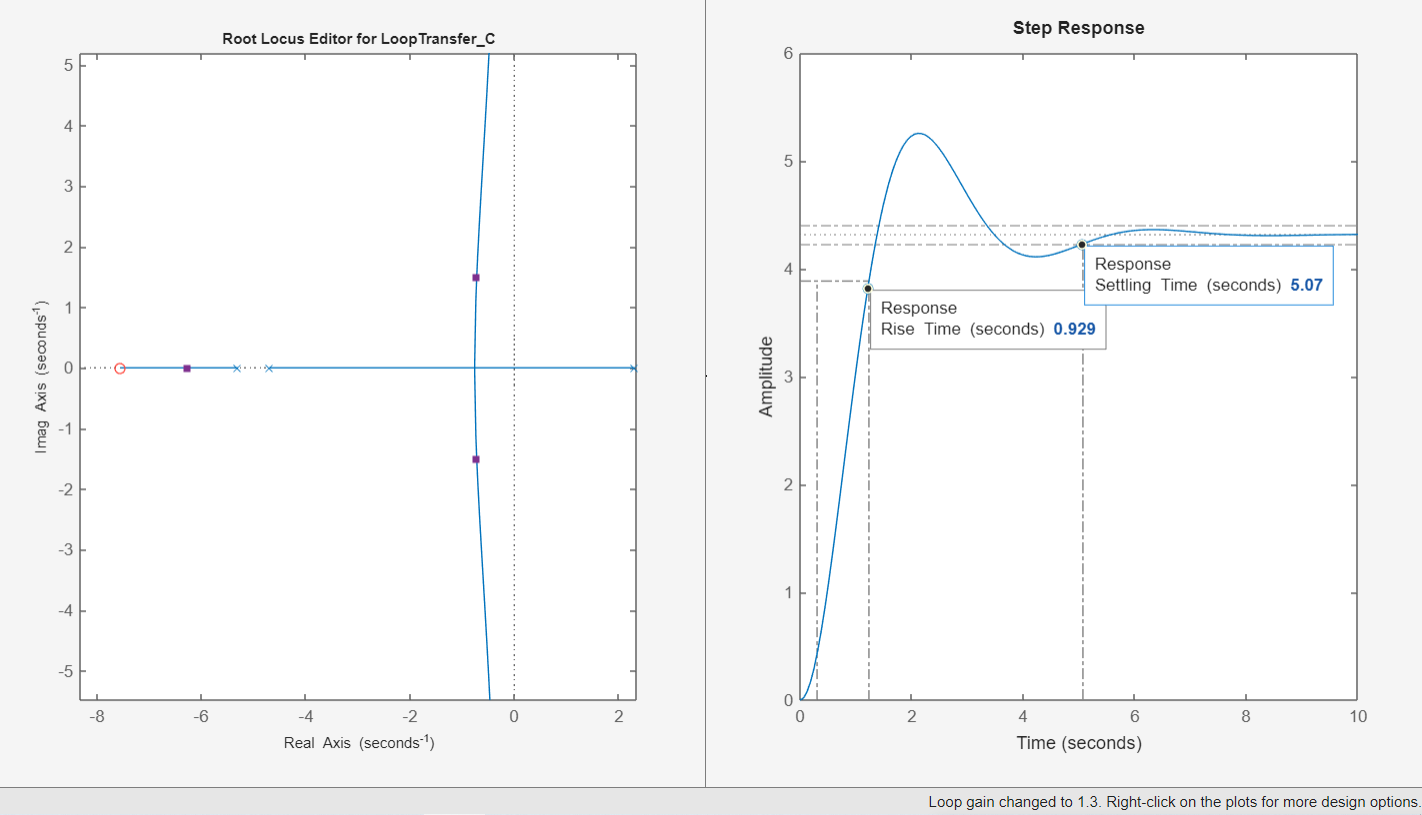

In [ ]:
# Resposta do Matlab
print(f"Tempo de Subida: 0.929s")
print(f"Tempo de Acomodação: 5.07s")
print(f"Ganho: 1.3")
Image(filename='/content/Figura 7.1.png')

Conclui-se que adicionar um zero ao sistem é suficiente, o que significa que foi necessário projetar um controlador PD. Os cálculos anteriores nos forneceram uma boa aproximação. Ainda que o ganho calculado não seja exatamente igual ao ganho experimental, o valor obtido é bastante próximo, com uma discrepância relativa de 5,79%. Esse valor é aceitável, considerando os erros de arredondamento nos cálculos e a dificuldade em realizar pequenas variações no ganho usando a ferramenta rltool, para que o ganho experimental se aproximasse ainda mais do ganho teórico. Apesar dessa pequena diferença, os requisitos de tempo de resposta foram atendidos
\
\
Em relação os parametros do controlado PD, temos que:

*   A constante de tempo do derivador será $\frac{1}{7.5}=0.133$
*   O ganho proporcional será $\frac{1.3}{T_d}=9.77$ e


###III.b)
Se o zero ideal estiver muito próximo do eixo imaginário, um acrescimo  de 0.01 pode alocar o zero no semiplano esquerdo, graficamente isto significa que um dos ramos do Root Locus cruzará o eixo imaginário.O impacto fisico disso na resposta ao degrau será a formação de oscilações e por isso não poderemos garantir estabilidade. Como no item anterior o zero estava bem longe do eixo imaginário (-7.5), uma variação de 0.01 não influencia tanto a resposta, mas é possível verificar uma sutil mudança no tempo de acomodação. Em relação ao tempo de subida, é necessário lembrar que com um menor amortecimento, o sistema se torna mais oscilatório, retardando o tempo de subida.

###III.c)
Nesta estapa projetaremos um controlador PID, que possui a seguinte forma: $H(s)= \frac{K_p}{T_i ⋅s}+ K_p + K_p\cdot T_d s= \frac{Ki+K_p⋅s+K_d⋅s^2}{s}=\frac{K⋅(s+Z_1)(s+Z_2)}{s} $.
\
\
 $H(s)= \frac{K⋅s^2+K⋅(Z_1+Z_2)⋅s+K⋅Z_1⋅Z_2}{s} $.
\
\
Sendo:

*   $K = K_d$
*   $K⋅(Z_1+Z_2)= K_P$
*   $K⋅Z_1\cdot Z_2=K_i$


Além disto, queremos atender aos seguintes requisitos:


*   Tempo de acomodação ($T_s$) em torno de 5s  
*   Percentual de overshoot($P.O$) limite igual a 15%

Em suma, a partir de conclusões anteriores primeiro vamos projetar um controlador PD para melhorar as especificações em regime transiente, depois projetar um controlador PI para melhorar as especificações em regime estacionário e por fim unir ambos.

In [ ]:
# Automatizando a tarefa de encontrar os zeros
def encontra_zeros(w, po, ts):
  # Encontrando o ponto desejado
  sigma = 4/ts #Parte real
  zeta = -np.log(po / 100) / np.sqrt(np.pi**2 + np.log(po / 100)**2)
  print(f'Zeta: {zeta}')
  phi = np.arccos(zeta) #Intervalo angular desejado
  phi_graus = np.degrees(phi)
  W_d = sigma*np.tan(phi)  #Parte imaginaria

  print(f'Intervalo real (sigma): {sigma :.4}')
  print(f'Intervalo angular desejado (phi): {phi_graus :.4}° ou {phi :.4} rad')
  print(f'Frequência de corte (Wd): {W_d:.4}')

  #Juntando os parametros para encontrar o polo desejado
  polo_desejado = complex(sigma, W_d)
  print(f"O polo desejado é: {polo_desejado}")

  polos = ct.poles(w)
  somatorio_angulos = 0
  modulo = 0
  for polo in polos:
    fase = np.angle(-polo+polo_desejado)
    somatorio_angulos += np.degrees(fase)
    if modulo == 0:
      modulo = -polo+polo_desejado
    else:
      modulo = modulo*(-polo+polo_desejado)
  modulo = np.abs(modulo)

  print(f"O somatorio dos angulos é: {somatorio_angulos}")
  print(f"O modulo do produto dos polos pelo produto dos zeros avaliado s igual ao polo desejado  é: {modulo}")

  z_1=  (W_d - (sigma * np.tan(somatorio_angulos)))/np.tan(somatorio_angulos)
  print(f"A posição do zero é: {-z_1}")

  ganho = modulo/(np.abs(z_1+polo_desejado)*57.293)
  print(f"O ganho(K_d) é: {ganho}")


encontra_zeros(G,0.15,5)

Zeta: 0.9004130149944255
Intervalo real (sigma): 0.8
Intervalo angular desejado (phi): 25.79° ou 0.4501 rad
Frequência de corte (Wd): 0.3865
O polo desejado é: (0.8+0.386521372751045j)
O somatorio dos angulos é: 173.19591006837643
O modulo do produto dos polos pelo produto dos zeros avaliado s igual ao polo desejado  é: 52.201580528150934
A posição do zero é: -0.09342595847253593
O ganho(K_d) é: 0.9359821488007053


No código anterior encontramos o zero introduzido pela ação do controlador PD, agora vamos reutilizá-lo acrescentando o polo na origem e encontrar o zero introduzido pelo controlador PI.

In [ ]:
num = [57.293]
den = [1, 7.7, 1.91, -57.293,0]
G_2 = ct.tf(num, den)
encontra_zeros(G_2,0.15,5)

Zeta: 0.9004130149944255
Intervalo real (sigma): 0.8
Intervalo angular desejado (phi): 25.79° ou 0.4501 rad
Frequência de corte (Wd): 0.3865
O polo desejado é: (0.8+0.386521372751045j)
O somatorio dos angulos é: 198.9835006380182
O modulo do produto dos polos pelo produto dos zeros avaliado s igual ao polo desejado  é: 46.380120819088
A posição do zero é: 0.584995534507833
O ganho(K_d) é: 1.830279294822145
